In [23]:
!unzip samples.zip

Archive:  samples.zip
   creating: samples/
   creating: samples/0/
   creating: samples/7/
   creating: samples/6/
   creating: samples/1/
   creating: samples/4/
   creating: samples/3/
   creating: samples/2/
   creating: samples/5/
  inflating: samples/0/0_79.wav      
  inflating: samples/0/0_45.wav      
  inflating: samples/0/0_51.wav      
  inflating: samples/0/0_86.wav      
  inflating: samples/0/0_92.wav      
  inflating: samples/0/0_93.wav      
  inflating: samples/0/0_87.wav      
  inflating: samples/0/0_50.wav      
  inflating: samples/0/0_44.wav      
  inflating: samples/0/0_78.wav      
  inflating: samples/0/0_52.wav      
  inflating: samples/0/0_46.wav      
  inflating: samples/0/0_91.wav      
  inflating: samples/0/0_85.wav      
  inflating: samples/0/0_84.wav      
  inflating: samples/0/0_90.wav      
  inflating: samples/0/0_47.wav      
  inflating: samples/0/0_53.wav      
  inflating: samples/0/0_57.wav      
  inflating: samples/0/0_43.wav      
  in

In [21]:
import shutil

# Caminho para a diretoria que deseja remover
diretoria = 'samples'

# Remover a diretoria e todo o seu conteúdo
shutil.rmtree(diretoria)

print(f'A diretoria {diretoria} foi removida com sucesso.')


A diretoria samples foi removida com sucesso.


In [24]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, Flatten, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from IPython.display import Audio, display

In [25]:
# Caminho para os dados e lista de comandos (sem 'rodar')
data_path = 'samples'
commands = ['frente', 'tras', 'esquerda', 'direita', 'mais', 'menos', 'parar']

In [26]:
# Função de aumento de dados para áudio
def augment_data(audio, sr):
    augmented = []

    # Original
    augmented.append(audio)

    # Time Shifting
    shift = np.random.randint(len(audio))
    augmented.append(np.roll(audio, shift))

    # Speed Tuning
    speed_change = np.random.uniform(0.8, 1.2)
    augmented.append(librosa.effects.time_stretch(audio.astype(float), rate=speed_change))

    # Pitch Shifting
    pitch_change = np.random.randint(-5, 5)
    augmented.append(librosa.effects.pitch_shift(audio.astype(float), sr=sr, n_steps=pitch_change))

    # Adding noise
    noise = np.random.randn(len(audio))
    augmented.append(audio + 0.005 * noise)

    return augmented

# Função para carregar e preprocessar os dados de áudio com aumento de dados
def load_data_with_augmentation(data_path, commands, max_len=128):
    X = []
    y = []
    for idx, command in enumerate(commands):
        command_path = os.path.join(data_path, str(idx))
        if not os.path.exists(command_path):
            print(f"Diretório {command_path} não encontrado, pulando...")
            continue
        for file_name in os.listdir(command_path):
            file_path = os.path.join(command_path, file_name)
            audio, sr = librosa.load(file_path, sr=None)
            augmented_audios = augment_data(audio, sr)
            for aug_audio in augmented_audios:
                # Mel-spectrogram
                mel_spectrogram = librosa.feature.melspectrogram(y=aug_audio, sr=sr, n_mels=128)
                mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

                # Pad or truncate the spectrogram to ensure uniform shape
                if mel_spectrogram.shape[1] > max_len:
                    mel_spectrogram = mel_spectrogram[:, :max_len]
                else:
                    pad_width = max_len - mel_spectrogram.shape[1]
                    mel_spectrogram = np.pad(mel_spectrogram, ((0, 0), (0, pad_width)), mode='constant')

                X.append(mel_spectrogram)
                y.append(idx)
    X = np.array(X)
    y = np.array(y)
    return X, y

In [27]:
# Função para plotar um espectrograma
def plot_spectrogram(mel_spectrogram, sr, title='Espectrograma'):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_spectrogram, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Função para carregar e plotar áudios e espectrogramas
def visualize_audios(data_path, commands):
    for idx, command in enumerate(commands):
        command_path = os.path.join(data_path, str(idx))
        if not os.path.exists(command_path):
            print(f"Diretório {command_path} não encontrado, pulando...")
            continue
        file_list = os.listdir(command_path)
        if not file_list:
            print(f"Nenhum arquivo encontrado em {command_path}, pulando...")
            continue
        file_name = file_list[0]  # Pega o primeiro arquivo da pasta
        file_path = os.path.join(command_path, file_name)

        # Carregar áudio
        audio, sr = librosa.load(file_path, sr=None)

        # Gerar Mel-spectrograma
        mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128)
        mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

        # Plotar áudio e espectrograma
        print(f"Visualizando o comando: {command}")

        # Plotar o waveform
        plt.figure(figsize=(10, 4))
        plt.plot(audio)
        plt.title(f'Waveform do comando: {command}')
        plt.xlabel('Amostras')
        plt.ylabel('Amplitude')
        plt.show()

        # Plotar espectrograma
        plot_spectrogram(mel_spectrogram, sr, title=f'Espectrograma do comando: {command}')

        # Ouvir áudio
        display(Audio(audio, rate=sr))

Visualizando o comando: frente


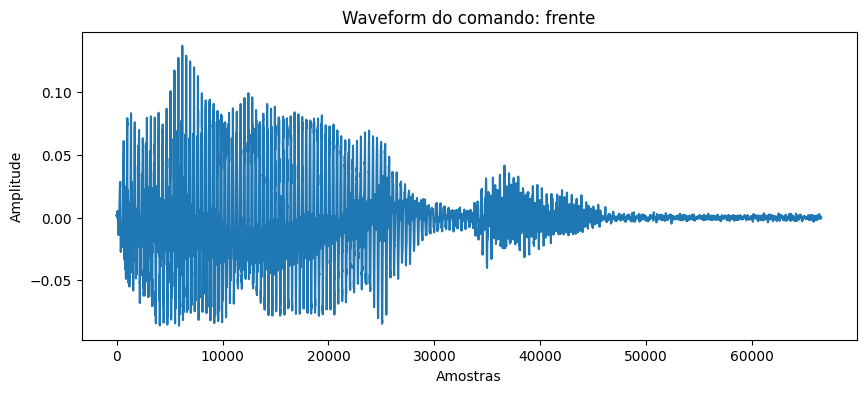

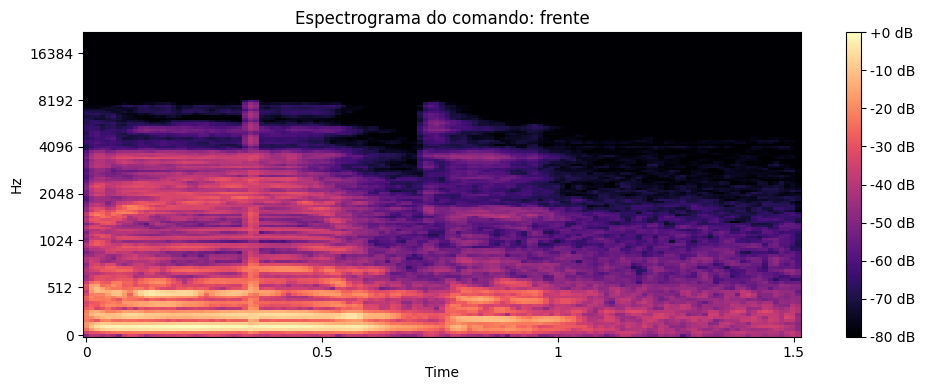

Visualizando o comando: tras


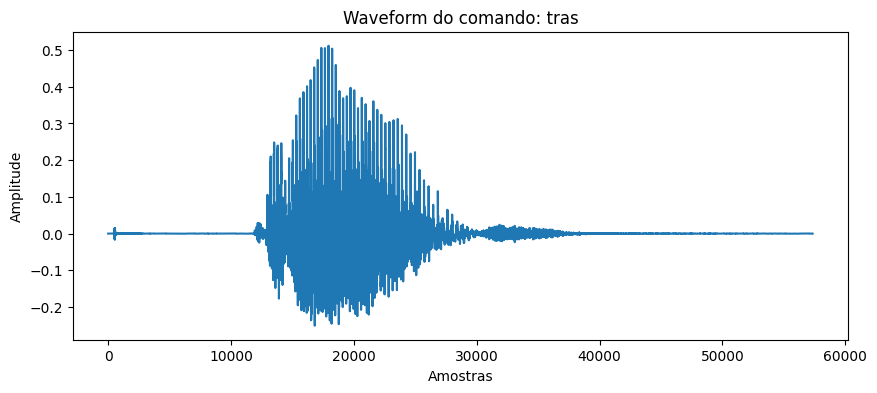

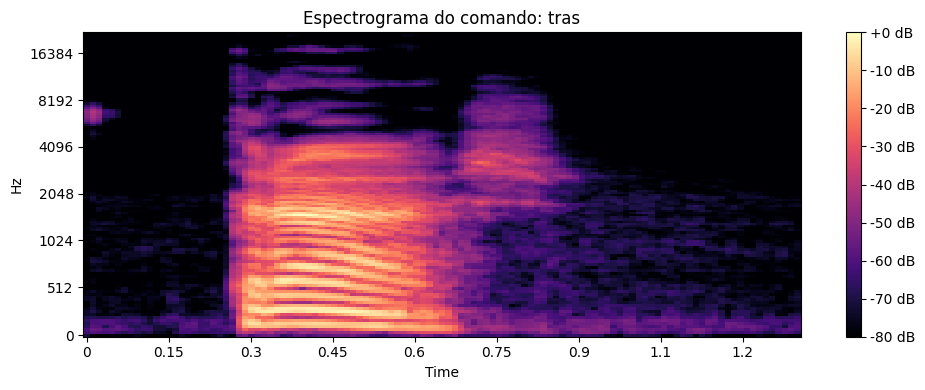

Visualizando o comando: esquerda


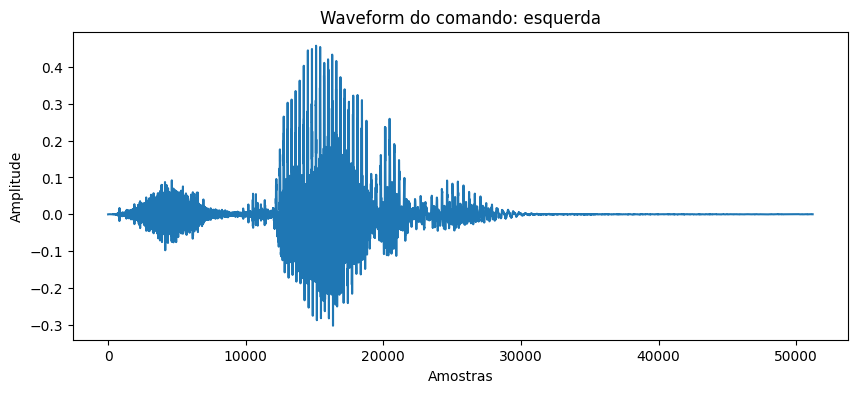

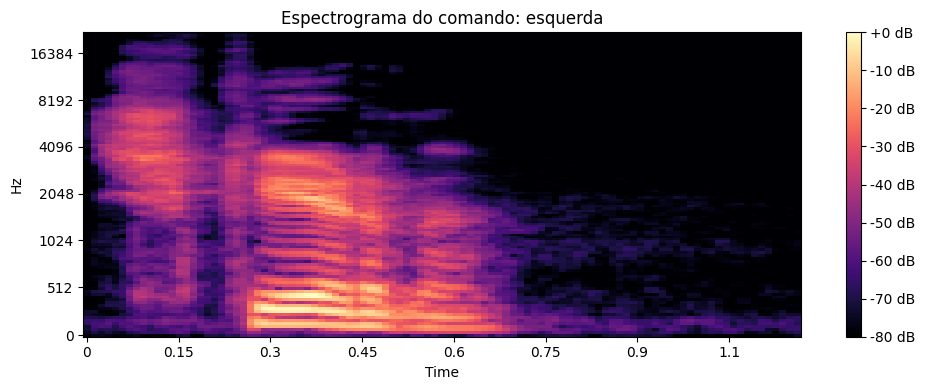

Visualizando o comando: direita


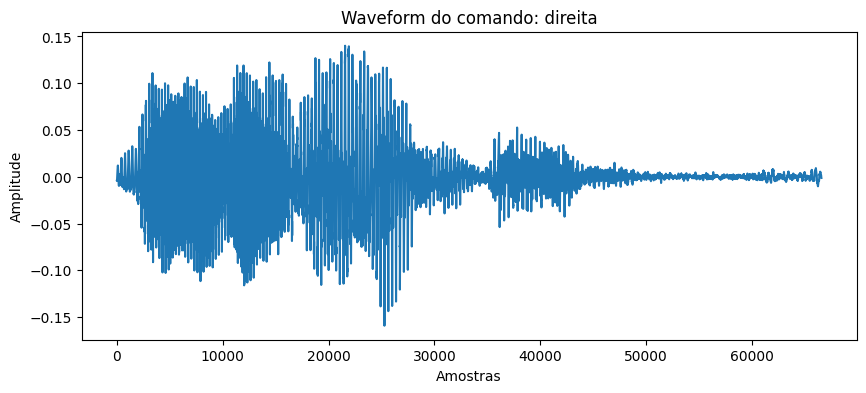

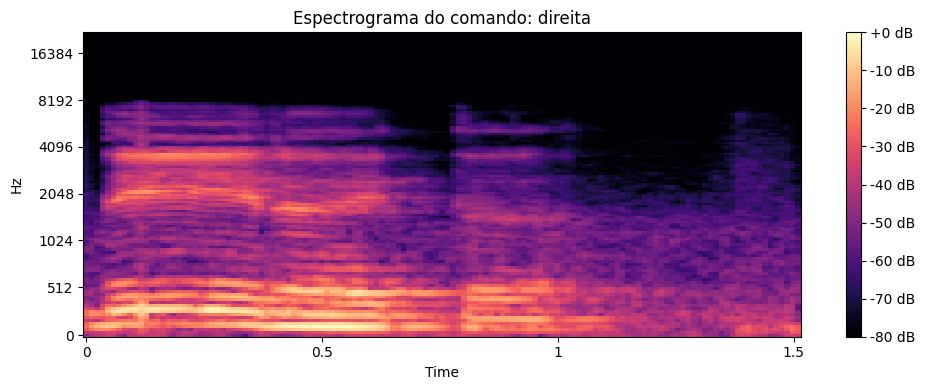

Visualizando o comando: mais


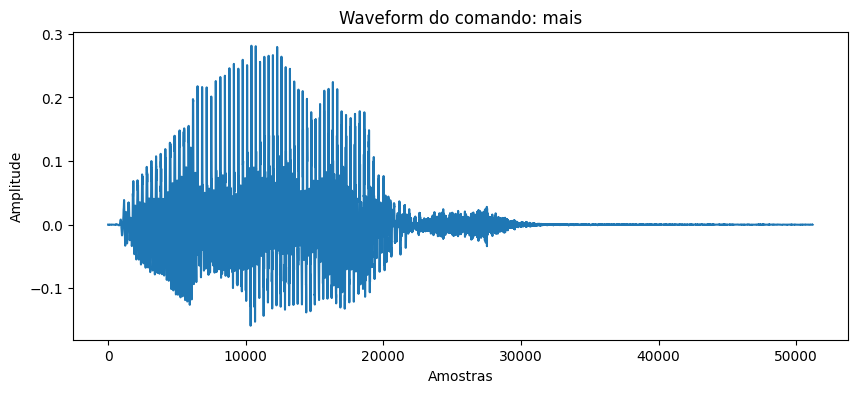

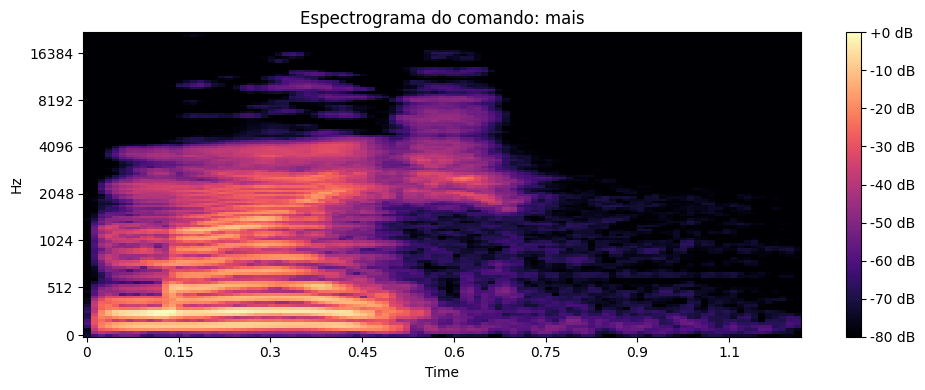

Visualizando o comando: menos


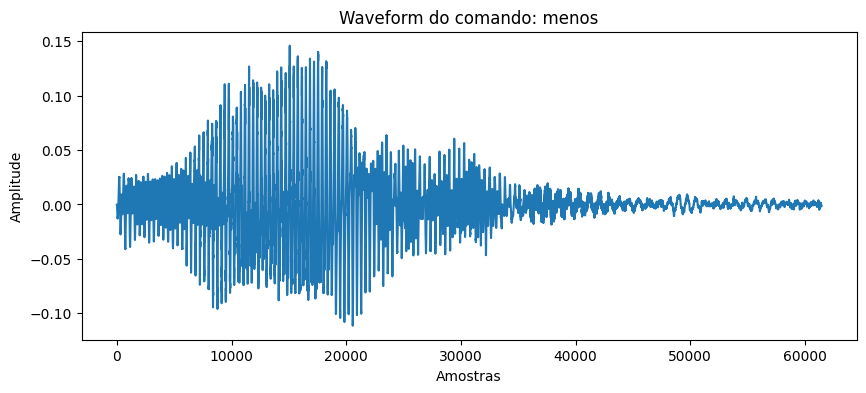

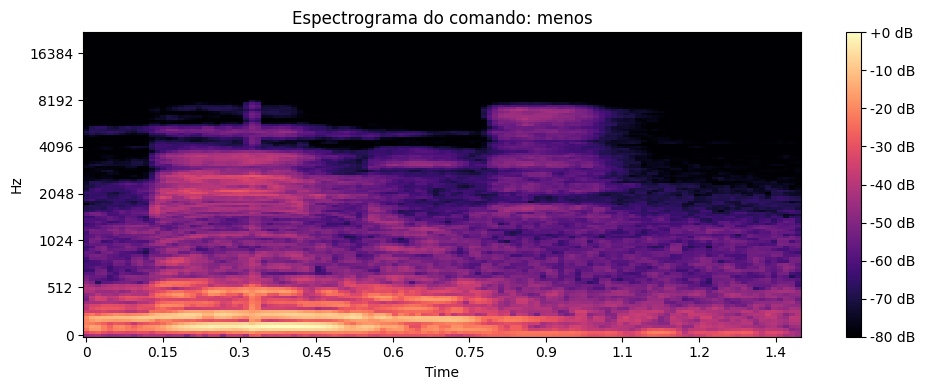

Visualizando o comando: parar


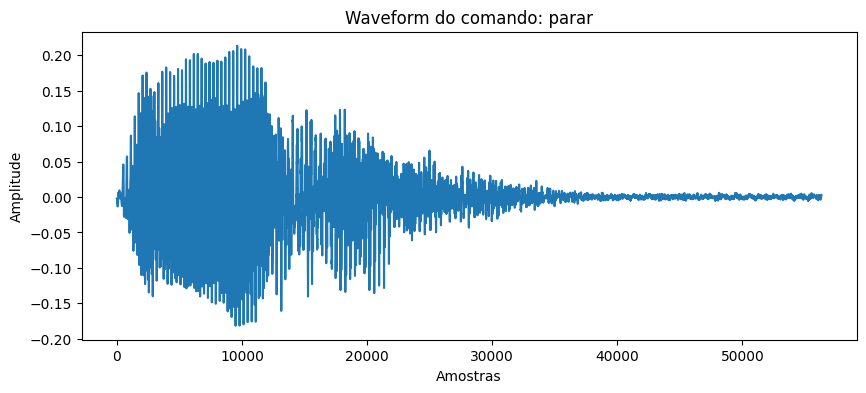

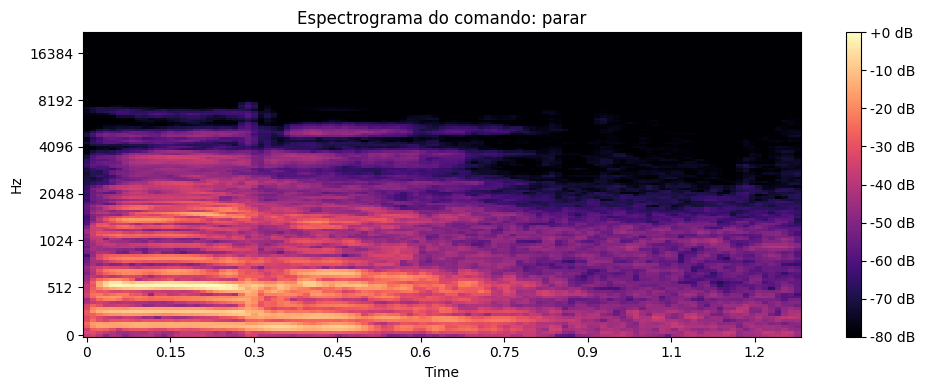

In [28]:
# Visualizar áudios e espectrogramas
visualize_audios(data_path, commands)

In [29]:
# Carregar dados
X, y = load_data_with_augmentation(data_path, commands)
y = to_categorical(y, num_classes=len(commands))

In [30]:
# Expandir a dimensão de X para incluir o canal (necessário para Conv2D)
X = np.expand_dims(X, -1)

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Construir modelo
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]), kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.5),
    BatchNormalization(),
    Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.5),
    BatchNormalization(),
    Flatten(),
    Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(0.5),
    BatchNormalization(),
    Dense(len(commands), activation='softmax')
])

In [ ]:
# Compilar o modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 63, 63, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_29 (Dropout)        (None, 63, 63, 32)        0         
                                                                 
 batch_normalization_24 (Ba  (None, 63, 63, 32)        128       
 tchNormalization)                                               
                                                                 
 conv2d_17 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 30, 30, 64)      

In [ ]:
# Treinar o modelo e armazenar histórico
history = model.fit(X_train, y_train, epochs=40, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Salvar o modelo
model.save('voice_command_model.h5')


Epoch 1/40
88/88 [==============================] - 76s 858ms/step - loss: 2.5532 - accuracy: 0.8239 - val_loss: 2.9122 - val_accuracy: 0.6357
Epoch 2/40
88/88 [==============================] - 73s 828ms/step - loss: 2.3429 - accuracy: 0.8318 - val_loss: 3.4183 - val_accuracy: 0.5700
Epoch 3/40
88/88 [==============================] - 72s 821ms/step - loss: 2.1971 - accuracy: 0.8396 - val_loss: 2.3650 - val_accuracy: 0.7314
Epoch 4/40
88/88 [==============================] - 72s 816ms/step - loss: 1.9724 - accuracy: 0.8629 - val_loss: 1.9555 - val_accuracy: 0.8600
Epoch 5/40
88/88 [==============================] - 71s 813ms/step - loss: 2.0103 - accuracy: 0.8629 - val_loss: 2.5192 - val_accuracy: 0.7571
Epoch 6/40
88/88 [==============================] - 73s 827ms/step - loss: 2.4220 - accuracy: 0.8300 - val_loss: 2.4650 - val_accuracy: 0.9171
Epoch 7/40
88/88 [==============================] - 69s 782ms/step - loss: 2.3655 - accuracy: 0.8589 - val_loss: 2.3051 - val_accuracy: 0.8829

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Função para plotar as estatísticas de treinamento
def plot_training_statistics(history):
    # Plotar a acurácia
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Acurácia Treino')
    plt.plot(history.history['val_accuracy'], label='Acurácia Validação')
    plt.xlabel('Épocas')
    plt.ylabel('Acurácia')
    plt.legend()
    plt.title('Acurácia durante o Treinamento')

    # Plotar a perda
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Perda Treino')
    plt.plot(history.history['val_loss'], label='Perda Validação')
    plt.xlabel('Épocas')
    plt.ylabel('Perda')
    plt.legend()
    plt.title('Perda durante o Treinamento')

    plt.show()

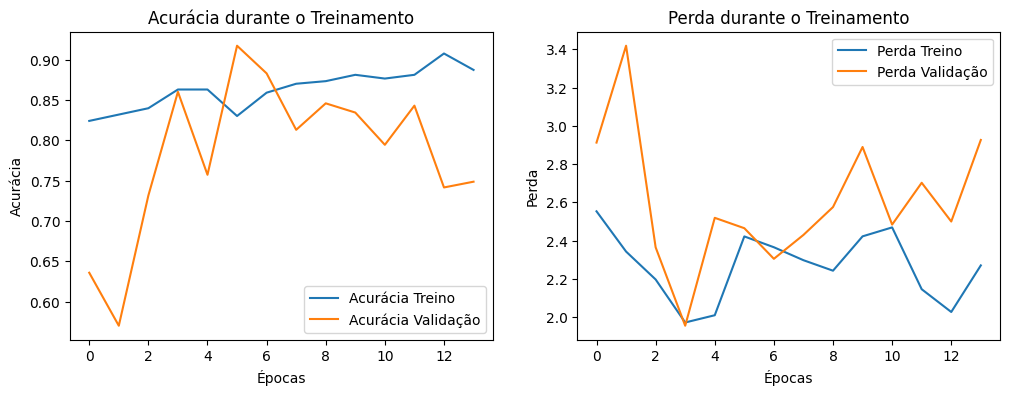

22/22 [==============================] - 4s 195ms/step


In [ ]:
# Plotar estatísticas de treinamento
plot_training_statistics(history)

# Avaliar o modelo no conjunto de teste
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Gerar matriz de confusão
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=commands)

<Figure size 1000x1000 with 0 Axes>

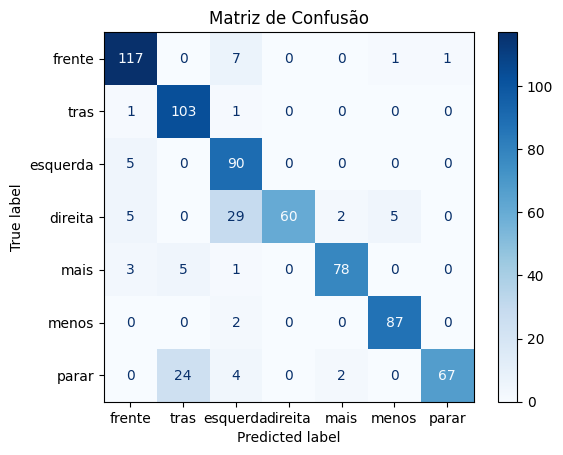

In [ ]:
# Plotar matriz de confusão
plt.figure(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Matriz de Confusão')
plt.show()

In [ ]:
!pip install tensorflowjs


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 46.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 MB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 57.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 79.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 71.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 55.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 62.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 46.0 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 5

In [ ]:
!tensorflowjs_converter --input_format keras voice_command_model.h5 ./modelo_tfjs


2024-07-22 17:29:40.790065: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-22 17:29:40.839710: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-22 17:29:40.839801: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-22 17:29:40.870917: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-22 17:29:43.685900: W tensorflow/compiler/tf

In [ ]:
import shutil
from google.colab import files

# Compactar a pasta modelo_tfjs
shutil.make_archive('modelo_tfjs', 'zip', './modelo_tfjs')

# Baixar o arquivo zipado
files.download('modelo_tfjs.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [31]:
# Função para carregar e preprocessar um único arquivo de áudio
def preprocess_audio(file_path, max_len=128):
    audio, sr = librosa.load(file_path, sr=None)
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128)
    mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

    # Pad or truncate the spectrogram to ensure uniform shape
    if mel_spectrogram.shape[1] > max_len:
        mel_spectrogram = mel_spectrogram[:, :max_len]
    else:
        pad_width = max_len - mel_spectrogram.shape[1]
        mel_spectrogram = np.pad(mel_spectrogram, ((0, 0), (0, pad_width)), mode='constant')

    mel_spectrogram = np.expand_dims(mel_spectrogram, -1)  # Add channel dimension
    mel_spectrogram = np.expand_dims(mel_spectrogram, 0)   # Add batch dimension

    return mel_spectrogram, sr

# Função para testar o modelo com cada comando e visualizar as previsões
def visualize_predictions(data_path, commands, model):
    for idx, command in enumerate(commands):
        command_path = os.path.join(data_path, str(idx))
        if not os.path.exists(command_path):
            print(f"Diretório {command_path} não encontrado, pulando...")
            continue
        file_list = os.listdir(command_path)
        if not file_list:
            print(f"Nenhum arquivo encontrado em {command_path}, pulando...")
            continue
        file_name = file_list[0]  # Pega o primeiro arquivo da pasta
        file_path = os.path.join(command_path, file_name)

        # Preprocessar áudio
        mel_spectrogram, sr = preprocess_audio(file_path)

        # Fazer previsão
        prediction = model.predict(mel_spectrogram)
        predicted_idx = np.argmax(prediction)
        predicted_command = commands[predicted_idx]

        # Plotar espectrograma e previsão
        mel_spectrogram = np.squeeze(mel_spectrogram, axis=0)  # Remover a dimensão do batch
        print(f"Comando verdadeiro: {command}")
        print(f"Comando previsto: {predicted_command}")

        plt.figure(figsize=(10, 4))
        librosa.display.specshow(mel_spectrogram[:, :, 0], sr=sr, x_axis='time', y_axis='mel')
        plt.colorbar(format='%+2.0f dB')
        plt.title(f'Espectrograma do comando: {command} - Previsto: {predicted_command}')
        plt.show()

        # Ouvir áudio
        audio, sr = librosa.load(file_path, sr=None)
        display(Audio(audio, rate=sr))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
Comando verdadeiro: frente
Comando previsto: frente


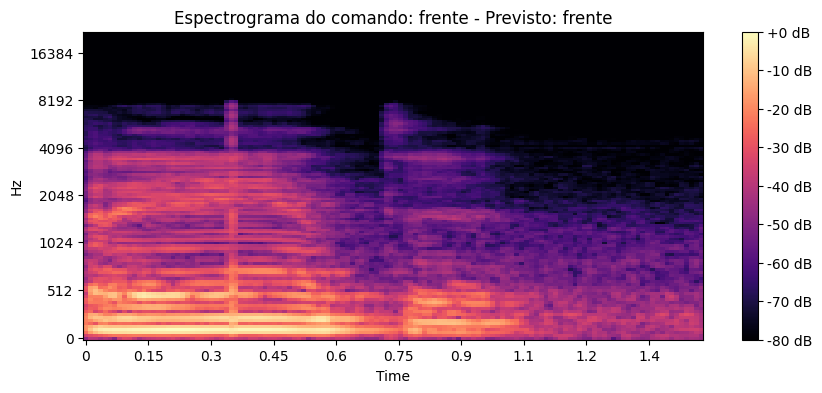

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Comando verdadeiro: tras
Comando previsto: tras


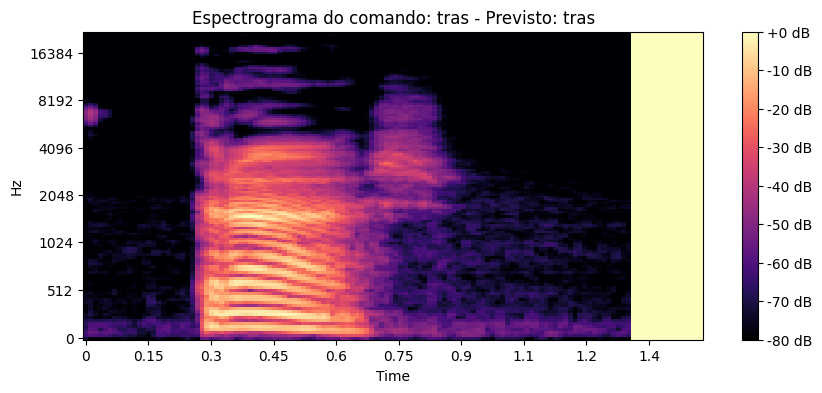

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Comando verdadeiro: esquerda
Comando previsto: esquerda


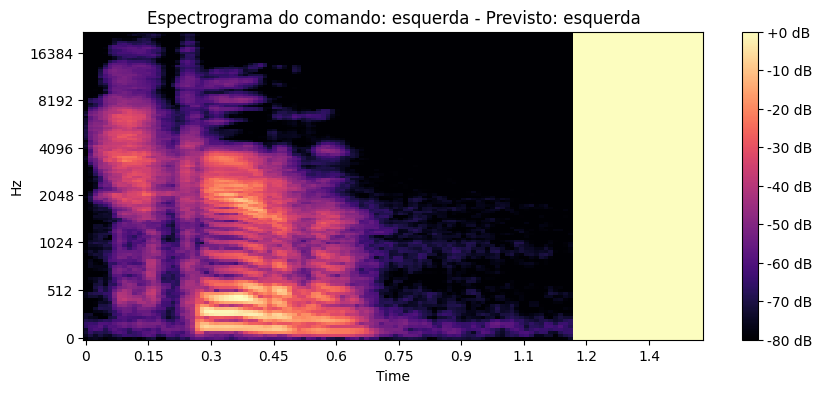

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Comando verdadeiro: direita
Comando previsto: direita


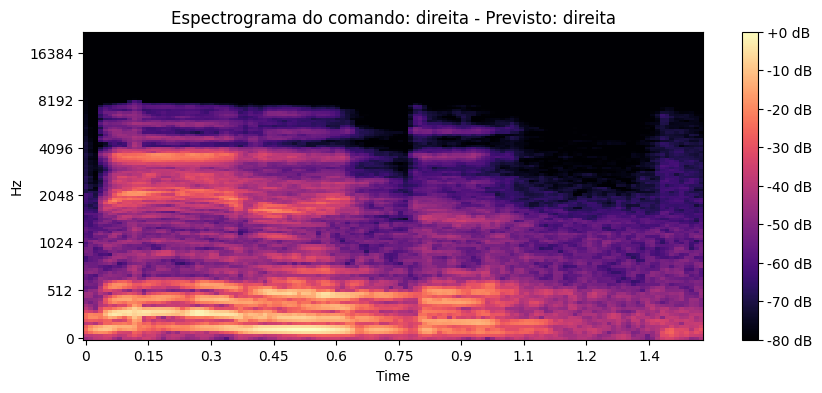

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Comando verdadeiro: mais
Comando previsto: mais


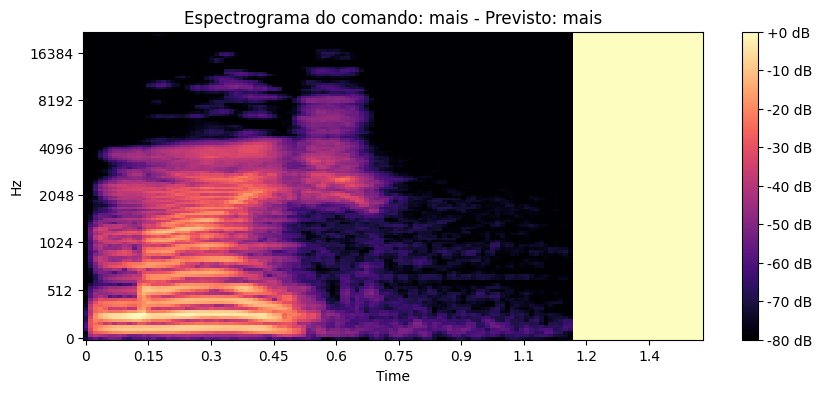

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Comando verdadeiro: menos
Comando previsto: menos


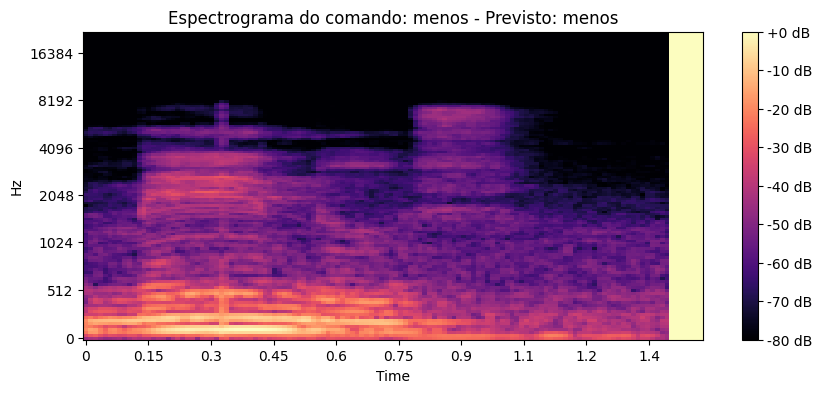

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Comando verdadeiro: parar
Comando previsto: parar


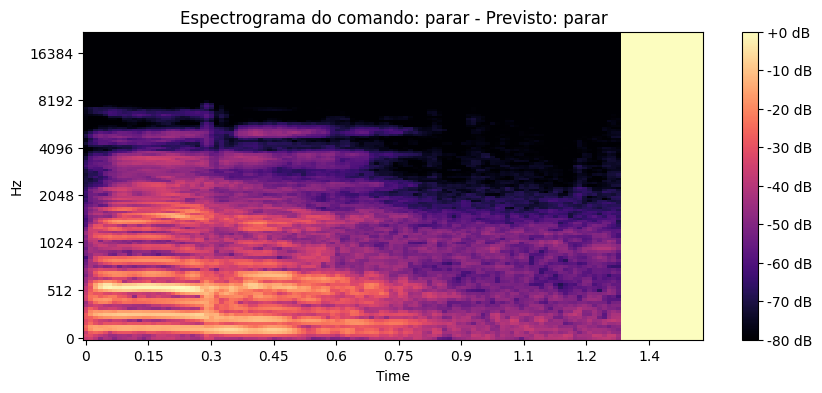

In [32]:
# Carregar o modelo salvo
model = tf.keras.models.load_model('voice_command_model.h5')

# Visualizar previsões
visualize_predictions(data_path, commands, model)